just adding changes for branch loso

# Study Area
Some code snippets, much borrowed from Mark Fahnestock, to download and view pertinent data related to our study area (the Grand Plateau Glacier and surroundings)

In [2]:
### import modules
# these might not all be necessary
import numpy as np
# import laspy as lp
from matplotlib import pyplot as plt
import matplotlib.image as mpimg
import sys
import os
import gdal
import osr
import os
import rasterio as rio
from rasterio import plot

# Load and display satellite image
This is a 50 m x 50 m sentinel 2 mosaic from the itslive project.
It is in EPSG 3413 (WGS 84 / NSIDC Polar Stereographic) with bounding box [min x, max x, min y, max y] -3450000, -3400000, 150000, 200000.

### Open the basemap with rasterio

In [11]:
basemap_fn = '/srv/shared/data-crossovers/GP_3413_50m.tif'
basemap_src = rio.open(basemap_fn)
basemap_src.profile
print(basemap_src.crs)
basemap_extent = rio.plot.plotting_extent(basemap_src)

EPSG:3413


not sure if following is useful?

In [41]:
basemap_src.profile['photometric'] = "RGBA"

### Read basemap as a NumPy masked array

In [23]:
basemap = basemap_src.read(1, masked=True)

### Create a quick plot

Plot with rasterio (uses bad colormap)

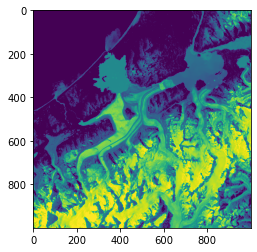

In [54]:
rio.plot.show(basemap)

Plot with matplot (uses good colormap)

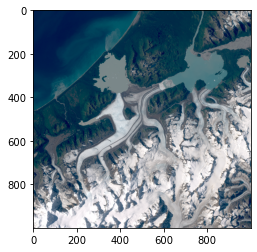

In [57]:
plt.imshow(mpimg.imread(basemap_fn))

# Import ArcticDEM
Jun was right--Polar Geospatial Center's website is down. Luckily I already have downloaded the DEM of interest. If you wanted to get it yourself when the PGC website was running, you'd go to http://data.pgc.umn.edu/elev/dem/setsm/ArcticDEM/mosaic/v3.0/2m/42_06/42_06_2_2_2m_v3.0.tar.gz and then extract the DEM from that archive. 

I've saved it (for now) at crossovers/contributors/loso/ArcticDEM

### Find and open dem as a dataset object using rasterio

Rasterio documentation: https://rasterio.readthedocs.io/en/stable/

In [13]:
path_to_ArcticDEM_folder = '/srv/shared/data-crossovers/ArcticDEM/42_06_2_2_2m_v3.0_reg_dem.tif'
ArcticDEM_src = rio.open(path_to_ArcticDEM_folder)

In [14]:
print(ArcticDEM_src.crs)

PROJCS["unnamed",GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AUTHORITY["EPSG","4326"]],PROJECTION["Polar_Stereographic"],PARAMETER["latitude_of_origin",70],PARAMETER["central_meridian",-45],PARAMETER["false_easting",0],PARAMETER["false_northing",0],UNIT["metre",1],AXIS["Easting",SOUTH],AXIS["Northing",SOUTH]]


In [3]:
ArcticDEM_src.profile
print(ArcticDEM_src.crs)
ArcticDEM_extent = rio.plot.plotting_extent(ArcticDEM_src)
print(ArcticDEM_extent)

PROJCS["unnamed",GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AUTHORITY["EPSG","4326"]],PROJECTION["Polar_Stereographic"],PARAMETER["latitude_of_origin",70],PARAMETER["central_meridian",-45],PARAMETER["false_easting",0],PARAMETER["false_northing",0],UNIT["metre",1],AXIS["Easting",SOUTH],AXIS["Northing",SOUTH]]
(-3450000.0, -3400000.0, 150000.0, 200000.0)


### Create NumPY array

In [3]:
arcticdem = ArcticDEM_src.read(1, masked=True)

In [ ]:
f, ax = plt.subplots()
ax.imshow(arcticdem, extent=ArcticDEM_extent);

In [ ]:
rio.plot.show(arcticdem)

# Appendix A: Sampling a raster at points

This is something that is surprisingly common, but may not be simple to implement.  Let's discuss a few options:
1. Simple `rasterio` sampling with integer indices using nearest neighbor
2. Statistics extracted for a circular window around each point location
3. NumPy/SciPy interpolation routines

This next bit is from David Shean

### Open the file with rasterio

https://rasterio.readthedocs.io/en/stable/

In [ ]:
arcticdem_src.profile

In [ ]:
arcticdem_src.crs

In [ ]:
arcticdem_extent = rio.plot.plotting_extent(arcticdem_src)

### Read as a NumPy Masked array

In [ ]:
f, ax = plt.subplots()
ax.imshow(arcticdem, extent=srtm_extent);

## Generate shaded relief map
* Many ways to do this, but we'll just use the `gdaldem` command line utility for simplicity

In [ ]:
hs_fn = os.path.splitext(srtm_fn)[0]+'_hs.tif'
if not os.path.exists(hs_fn):
    !gdaldem hillshade $srtm_fn $hs_fn

In [ ]:
srtm_hs_src = rio.open(hs_fn)
hs = srtm_hs_src.read(1, masked=True)

## Plot color shaded relief map

In [ ]:
f, ax = plt.subplots()
ax.imshow(hs, cmap='gray', extent=rio.plot.plotting_extent(srtm_hs_src))
ax.imshow(srtm, extent=srtm_extent, alpha=0.5);

### Reproject GLAS points to match raster

In [ ]:
glas_gdf_srtm = glas_gdf_aea.to_crs(srtm_src.crs)

### Prepare the coordinate arrays to pass to rio `sample` function
* The `sample` function expects a list of (x,y) tuples: https://rasterio.readthedocs.io/en/latest/api/rasterio.sample.html
    * Need to create this from the `geometry` objects in your GeoDataFrame
    * You want a list of the form [(x1,y1),(x2,y2),…]
* Pass to `sample`
* Note that the `sample` function returns a `generator` object, and it doesn't actually evaluate the call!
* Can wrap this in a `np.array(list())` to evaluate, or use `np.fromiter()`
* This operation may take ~10-20 seconds to complete

In [ ]:
glas_coord = [(pt.x, pt.y) for pt in glas_gdf_srtm.geometry]
#glas_coord = np.vstack((glas_gdf_srtm.geometry.x.values, glas_gdf_srtm.geometry.y.values)).T

### Sample with rasterio

In [ ]:
glas_srtm_sample = srtm_src.sample(glas_coord)
glas_srtm_sample

### This is a generator, so we actually need to evaluate

In [ ]:
glas_srtm_elev = np.fromiter(glas_srtm_sample, dtype=srtm.dtype)
glas_srtm_elev

### Deal with nodata
* Some of our GLAS points are located over areas where we don't have valid DEM pixels
* These will be assigned the raster nodata value (-32768 in this case)

In [ ]:
glas_srtm_elev_ma = np.ma.masked_equal(glas_srtm_elev, srtm_src.nodata)
glas_srtm_elev_ma

### Add new column to the GeoDataFrame
* Set masked values to `np.nan` (which requires a conversion to float)

In [ ]:
glas_gdf_srtm['srtm_90m_z_rio'] = glas_srtm_elev_ma.astype(float).filled(np.nan)

In [ ]:
glas_gdf_srtm.dropna().head()

In [ ]:
f, ax = plt.subplots()
ax.imshow(hs, cmap='gray', extent=rio.plot.plotting_extent(srtm_hs_src))
#ax.imshow(srtm, extent=srtm_extent, alpha=0.5);
glas_gdf_srtm.dropna().plot('srtm_90m_z_rio', ax=ax, markersize=1);

*Note: the SRTM elevation values are height above the EGM96 geoid*

### Notes on sampling coarse rasters or noisy rasters at integer pixel locations
* The rasterio approach is efficient, but it uses a nearest neighbor algorithm to extract the elevation value for the grid cell that contains the point, regardless of where the point falls within the grid cell (center vs. corner)
* But the DEM grid cells can be big (~90x90 m for the SRTM3 data), so if point is near the corner of a pixel on steep slope, the pixel value might not be representative.
* A better approach is to use bilinear or bicubic sampling, to interpolate the elevation value at the point coordinate using pixel values within some neighborhood around the point, (e.g. 2x2 window for bilinear, 4x4 window for cubic)
* Other approaches involve computing zonal stats within some radius of the point location (e.g., median elevation of pixels within 300 m of the point, using buffer to create polygons)
    * https://www.earthdatascience.org/courses/earth-analytics-python/lidar-remote-sensing-uncertainty/extract-data-from-raster/
    * https://pysal.org/scipy2019-intermediate-gds/deterministic/gds2-rasters.html#getting-values-at-cells
    * https://github.com/dshean/pygeotools/blob/master/pygeotools/lib/geolib.py#L1019

### We will use the TANDEM-X Global DEM for our comparison. The resolution of the globally avaialable product is 90 m, with *horizontal* and *vertical* accuracy better than 2 to 3 m.
- TANDEM-X DEM for the region was downloaded and preprocessed, filtered using scripts from the [tandemx](https://github.com/dshean/tandemx) repository

In [18]:
dem_file = os.path.join(wd,'supporting_files/TDM1_DEM_90m_colombia_DEM_masked_aea.tif')
hs_file = os.path.splitext(dem_file)[0]+'_hs.tif'
dem_ds = rasterio.open(dem_file)

In [19]:
! gdaldem hillshade $dem_file $hs_file

0...10...20...30...40...50...60...70...80...90...100 - done.


In [20]:
hs_ds = rasterio.open(hs_file)

In [21]:
def gdf_on_raster(gdf,ds,ax,hs_ds=None,cmap='inferno'):
    gdf = gdf.to_crs(ds.crs)
    xmin,ymin,xmax,ymax = ds.bounds
    ndv = gda_lib.get_ndv(ds)
    img = ds.read(1)
    img = np.ma.masked_less_equal(img,ndv)
    clim = np.nanpercentile(img,(2,98))
    if hs_ds:
        hs = hs_ds.read(1)
        ndv = gda_lib.get_ndv(hs_ds)
        hs = np.ma.masked_less_equal(hs,ndv)
        ax.imshow(hs,cmap='gray',extent=[xmin,xmax,ymin,ymax])
        im = ax.imshow(img,alpha=0.6,cmap=cmap,extent=[xmin,xmax,ymin,ymax])
        print(clim)
    else:
        im = ax.imshow(img,cmap=cmap,vmin=clim[0],vmax=clim[1],extent=[xmin,xmax,ymin,ymax])
    gdf.plot('p_b',ax=ax,s=1)
    plt.colorbar(im,ax=ax,extend='both',label='Elevation (m)')

In [22]:
xmin,ymin,xmax,ymax = dem_ds.bounds

In [32]:
## Filter points based on DEM extent

In [23]:
gdf_colombia['x_atc'] = gdf_colombia['delta_time']
gdf_colombia_dem_extent = gdf_colombia.to_crs(dem_ds.crs).cx[xmin:xmax,ymin:ymax]

[-32767.           2951.64549805]


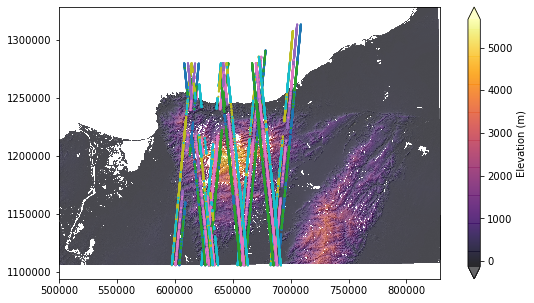

In [24]:
fig,ax = plt.subplots(figsize=(10,5))
gdf_on_raster(gdf_colombia_dem_extent,dem_ds,ax,hs_ds)